# Column Descriptions

- Target
    - HeartDisease: Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI).
    
- Continuous
    - BMI: Body Mass Index (BMI).
    - PhysicalHealth: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days).
    - MentalHealth: Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days).
    - AgeCategory: Fourteen-level age category. (then calculated the mean)
    - SleepTime: On average, how many hours of sleep do you get in a 24-hour period?
    
- Categorical:
    - Binary:
        - Stroke: (Ever told) (you had) a stroke?
        - DiffWalking: Do you have serious difficulty walking or climbing stairs?
        - Smoking: Have you smoked at least 100 cigarettes in your entire life?
        - AlcoholDrinking: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week
        - Asthma: (Ever told) (you had) asthma?
        - KidneyDisease: Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?
        - SkinCancer: (Ever told) (you had) skin cancer?
        - PhysicalActivity: Adults who reported doing physical activity or exercise during the past 30 days other than their regular job.
    - Other: 
        - Diabetic: (Ever told) (you had) diabetes?
        - Sex: Are you male or female?
        - Race: Imputed race/ethnicity value.
    - Ordered Categorical
        - GenHealth: Would you say that in general your health is...excellent, very good, etc.

In [4]:
from typing import List

#general
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from dython import nominal
from dython.nominal import associations

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})

In [94]:
def mean_of_age_category(row):
    if "older" in row:
        return 80
    else:
        return np.mean(list(map(int, row.split("-"))))


def data_preprocessing(data: pd.DataFrame, categorical_features: List[str], continuous_features: List[str], target_variable: str):
    
    df = data.copy()
    
    # subset df
    df = df[(df["Race"]=="White") | (df["Race"]=="Black")]
    df["AgeCategory"] = df["AgeCategory"].apply(mean_of_age_category)
    
    # target
    target = df[target_variable].values
    
    df_processed = df[categorical_features + continuous_features].copy() #.copy to avoid "SettingWithCopyWarning"

    # protected variables
    sex = df["Sex"].values
    age = df["AgeCategory"].values
    race = df["Race"].values
    
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_',
                                  dummy_na=False, columns=categorical_features, drop_first=True)

    return df_processed, df, target, sex, age, race

In [95]:
train = pd.read_csv('data/heart_train.csv')

target_variable = "HeartDisease"

continuous_features = list(train._get_numeric_data().columns) + ["AgeCategory"]

categorical_features = list(set(train.columns) - set(continuous_features) - set([target_variable]))

train_processed, train_original, train_target, train_sex, train_age, train_race = data_preprocessing(
    train, categorical_features=categorical_features, continuous_features=continuous_features, target_variable=target_variable)

In [96]:
from IPython.display import display

def describe_df(df, col):
    for val in df[col].unique():
        print("Race: ", val)
        display(df[df[col]==val].describe()[['BMI','PhysicalHealth','MentalHealth', 'AgeCategory', 'SleepTime']].T.style.background_gradient(cmap='Blues'))

In [97]:
describe_df(train_processed, "Race_White")

Race:  1


,count,mean,std,min,25%,50%,75%,max
BMI,171703.000000,28.150102,6.194493,12.020000,23.910000,27.170000,31.200000,94.850000
PhysicalHealth,171703.000000,3.356453,7.945803,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,171703.000000,3.811582,7.835912,0.000000,0.000000,0.000000,3.000000,30.000000
AgeCategory,171703.000000,56.251195,17.349985,21.000000,42.000000,57.000000,72.000000,80.000000
SleepTime,171703.000000,7.132951,1.368425,1.000000,6.000000,7.000000,8.000000,24.000000


Race:  0


,count,mean,std,min,25%,50%,75%,max
BMI,16100.000000,30.179532,7.190015,12.020000,25.100000,29.050000,33.840000,92.530000
PhysicalHealth,16100.000000,3.733851,8.176771,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,16100.000000,4.233975,8.396428,0.000000,0.000000,0.000000,4.000000,30.000000
AgeCategory,16100.000000,52.198944,17.001393,21.000000,37.000000,52.000000,67.000000,80.000000
SleepTime,16100.000000,7.003975,1.856217,1.000000,6.000000,7.000000,8.000000,24.000000


# Binary Feature Counts

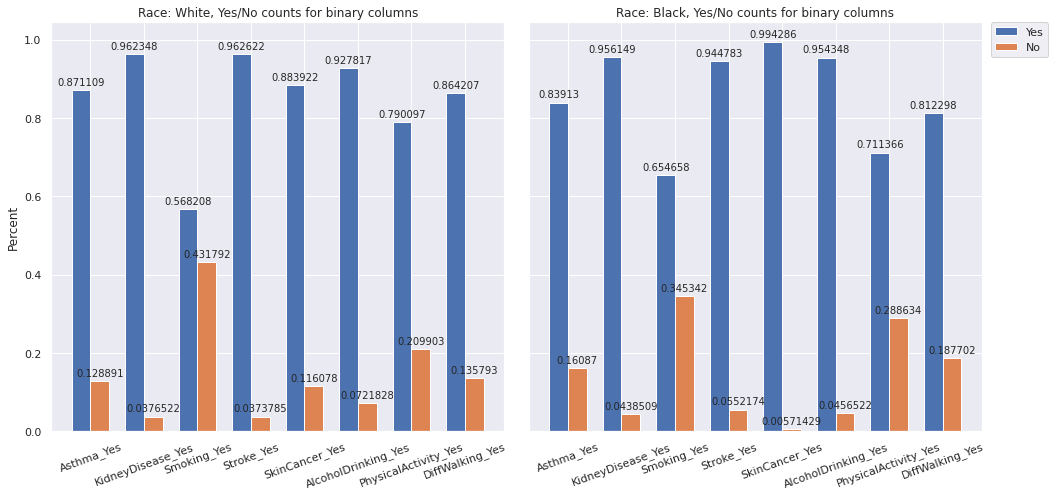

In [98]:
binary_features = ["Asthma_Yes", "KidneyDisease_Yes", "Smoking_Yes", "Stroke_Yes", 
                   "SkinCancer_Yes", "AlcoholDrinking_Yes", "PhysicalActivity_Yes", "DiffWalking_Yes"]

fig, ax = plt.subplots(1, 2, figsize=(14,7), sharey=True)
x = np.arange(len(binary_features))
width = 0.35

for val in train_processed["Race_White"].unique():
    no = []
    yes = []
    
    for col in binary_features:
        n, y = train_processed[train_processed["Race_White"]==val][col].value_counts(normalize=True).values
        no.append(n)
        yes.append(y)
    
    if val == 1:
        rects1 = ax[0].bar(x - width/2, no, width, label='No')
        rects2 = ax[0].bar(x + width/2, yes, width, label='Yes')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[0].set_ylabel('Percent')
        ax[0].set_title('Race: White, Yes/No counts for binary columns')
        ax[0].set_xticks(x, binary_features, rotation=20)
        
        ax[0].bar_label(rects1, padding=3)
        ax[0].bar_label(rects2, padding=3)
    else:
        rects1 = ax[1].bar(x - width/2, no, width, label='No')
        rects2 = ax[1].bar(x + width/2, yes, width, label='Yes')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[1].set_title('Race: Black, Yes/No counts for binary columns')
        ax[1].set_xticks(x, binary_features, rotation=20)
        
        ax[1].bar_label(rects1, padding=3)
        ax[1].bar_label(rects2, padding=3)

#ax.legend()

fig.tight_layout()
plt.legend(loc=2, labels=['Yes', 'No'], bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

# Continuous Counts

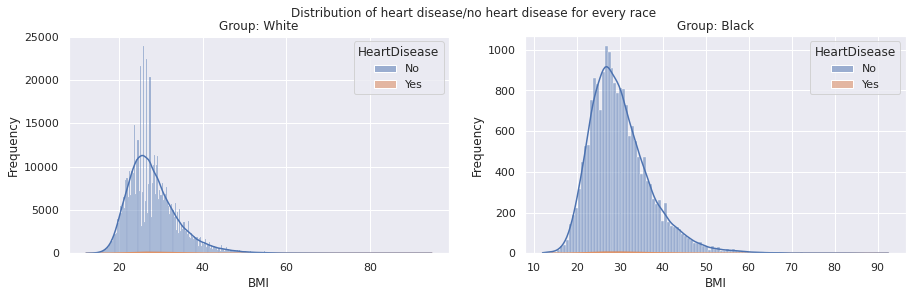

In [168]:
def histplot(df, target, groups, x_feature, colors=["#ea4335", '#4285f4']):
    # creating a figure composed of n_hist matplotlib.Axes objects
    f, ax_hist = plt.subplots(1, 2, figsize=(15,4))
    
    f.suptitle('Distribution of heart disease/no heart disease for every race')
    
    for i, group in enumerate(df[groups].unique()):
        sns.histplot(df[df[groups]==group], x=x_feature, hue=target, 
                         kde=True, stat="frequency", ax=ax_hist[i])
        ax_hist[i].set_title(f"Group: {group}")
    plt.show()

histplot(train_original, "HeartDisease", "Race", "BMI")    
    

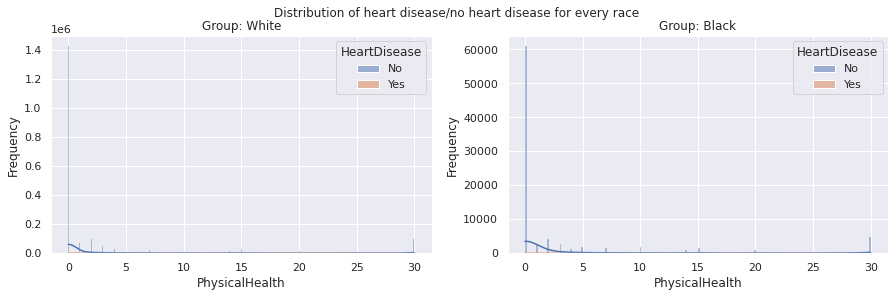

In [169]:
histplot(train_original, "HeartDisease", "Race", "PhysicalHealth")

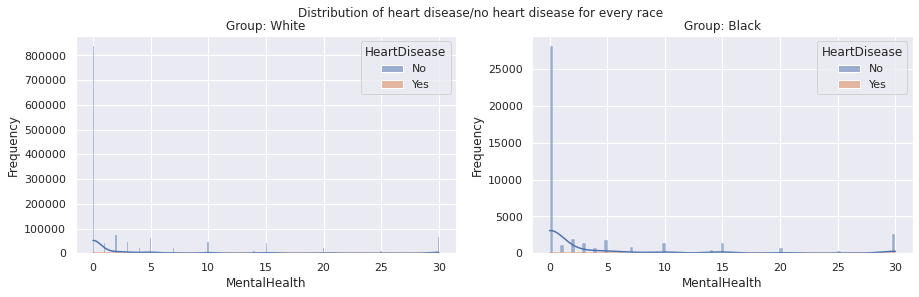

In [170]:
histplot(train_original, "HeartDisease", "Race", "MentalHealth")

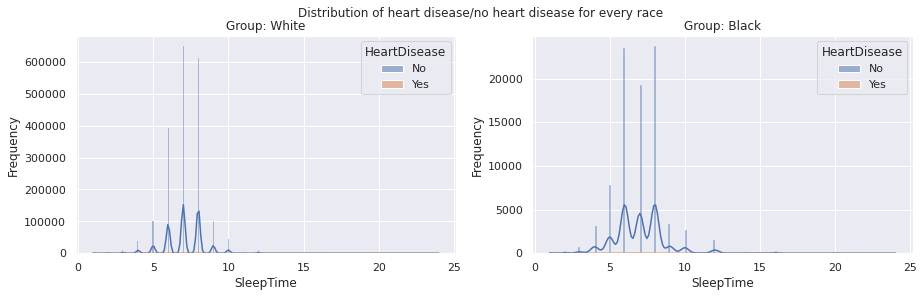

In [171]:
histplot(train_original, "HeartDisease", "Race", "SleepTime")

# Distribution of heartdisease, kidneydisease, skincancer across age category per race

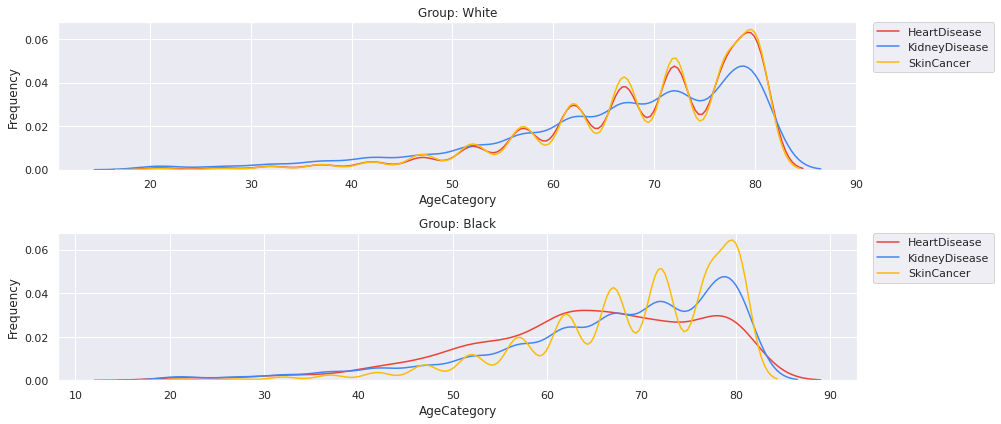

In [173]:
fig, ax = plt.subplots(2, 1, figsize = (14,6))

for i, group in enumerate(train_original["Race"].unique()):
    sns.kdeplot(train_original[(train_original["HeartDisease"]=="Yes") & (train_original["Race"]==group)]["AgeCategory"], alpha=1,shade = False, color="#ea4335", label="HeartDisease", ax = ax[i])
    sns.kdeplot(train_original[train_original["KidneyDisease"]=="Yes"]["AgeCategory"], alpha=1,shade = False, color="#4285f4", label="KidneyDisease", ax = ax[i])
    sns.kdeplot(train_original[train_original["SkinCancer"]=="Yes"]["AgeCategory"], alpha=1,shade = False, color="#fbbc05", label="SkinCancer", ax = ax[i])
    ax[i].set_title(f"Group: {group}")
    ax[i].set_xlabel("AgeCategory")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [188]:
print("White: ")
print(train_original[train_original["Race"]=="White"]["HeartDisease"].value_counts(normalize=True), "\n")
print("Black: ")
print(train_original[train_original["Race"]=="Black"]["HeartDisease"].value_counts(normalize=True))

White: 
No     0.908266
Yes    0.091734
Name: HeartDisease, dtype: float64 

Black: 
No     0.923416
Yes    0.076584
Name: HeartDisease, dtype: float64


----

# Diabetes for Categoricals across sex and race

In [214]:
target = "HeartDisease"
group = "Race"
subgroup = "Sex"
indexes = "AgeCategory"
categoricals = list(set(categorical_features) - set([group, subgroup]))
continuous = list(set(continuous_features) - set(["AgeCategory"]))

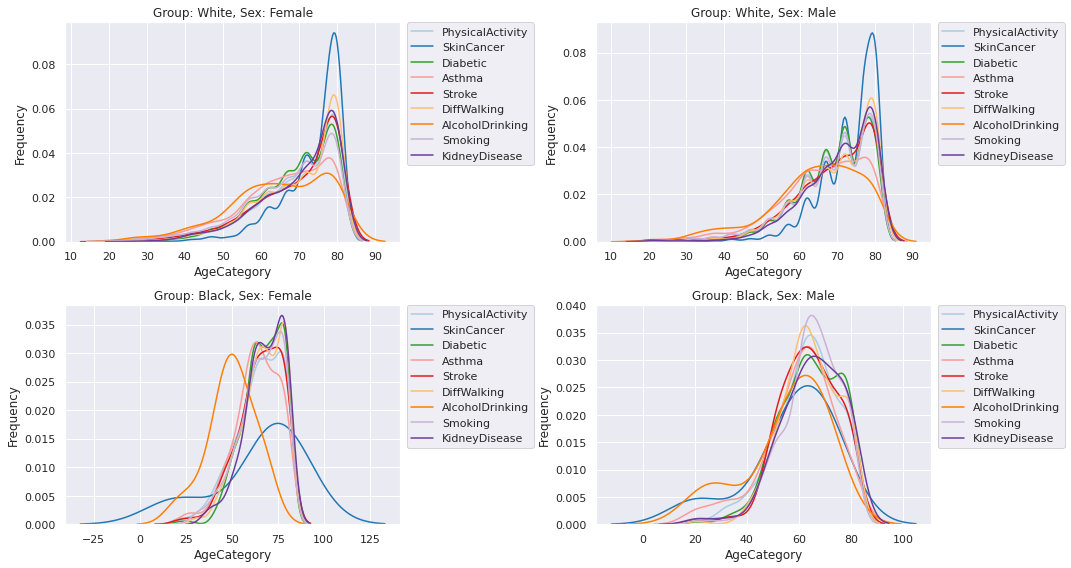

In [258]:
fig, axes = plt.subplots(2, 2, figsize= (15, 8))
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"]

for i, g in enumerate(train_original[group].unique()):
    for j, sex in enumerate(train_original[subgroup].unique()):
        for c, cat in enumerate(categoricals):
            sns.kdeplot(train_original[(train_original[target]=="Yes") 
                                   & (train_original[cat]=="Yes")
                                   & (train_original[group]==g) 
                                   & (train_original[subgroup]==sex)][indexes], alpha=1, shade=False, color=colors[c],
                   label=cat, ax=axes[i][j])
        axes[i][j].set_title(f"Group: {g}, Sex: {sex}")
        axes[i][j].set_xlabel("AgeCategory")
        axes[i][j].set_ylabel("Frequency")
        axes[i][j].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()      

# Correlations

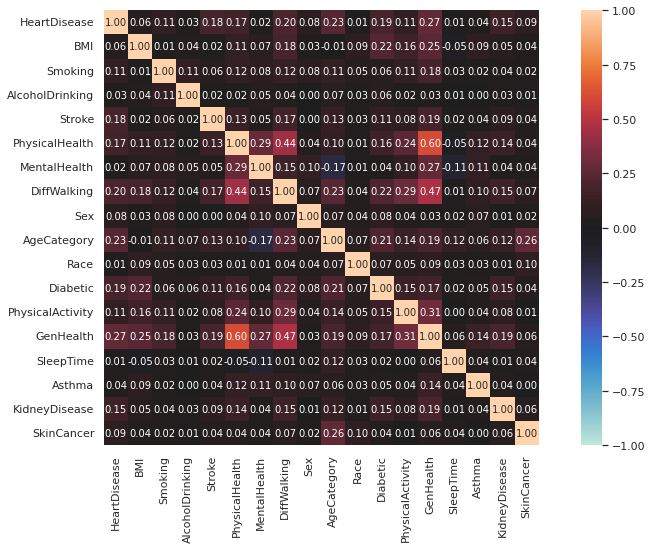

In [261]:
associations(train_original, figsize=(15, 8))
plt.show()